# ltu-ili jupyter interface
This is a tutorial for using the ltu-ili inference framework in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import sbi

from ili.dataloaders import NumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PlotRankStatistics, TARP

device='cpu'

/opt/homebrew/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/maho/git/ili-summarizer/summarizer/__init__.py:33: UserWarning: Running without the following backends due to ModuleNotFoundError: nbodykit, jax, Corrfunc, kymatio
  warnings.warn(f"Running without the following backends due to ModuleNotFoundError: {', '.join(notfound)}")


## Toy SNPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

In [2]:
# create synthetic catlog
def simulator(params):
    # create toy simulations
    x = np.linspace(0, 10, 20)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += 1*np.random.randn(len(x))
    return y

theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

Text(0.5, 1.0, 'Data vectors x')

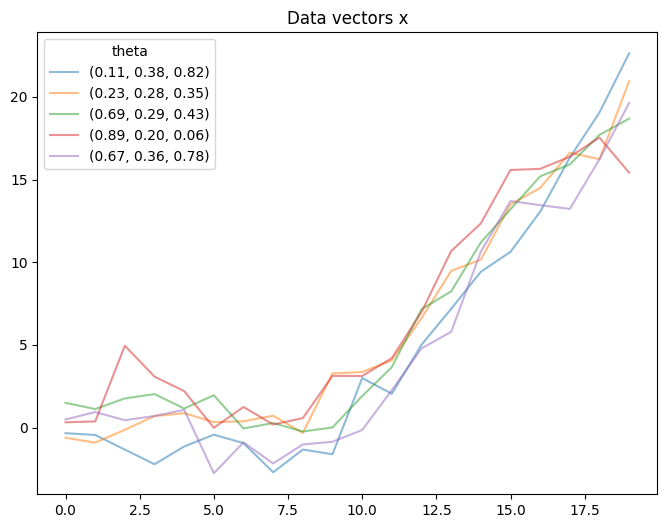

In [3]:
# plot some examples of the data
f, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')

In [4]:
# define a prior
prior = sbi.utils.BoxUniform(low=(0,0,0), high=(1,1,1))

# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# instantiate your neural networks to be used as an ensemble
nets = [
    sbi.utils.posterior_nn(model='maf', hidden_features=50, num_transforms=5),
    sbi.utils.posterior_nn(model='mdn', hidden_features=50, num_components=2)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = SBIRunner(
    prior=prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    output_path=None  # no output path, so nothing will be saved to file
)

In [5]:
# train the model. this outputs a posterior model and training logs
posterior, summaries = runner(loader=loader)

INFO:root:Training model 1 out of 2 ensemble models


 Training neural network. Epochs trained: 194

INFO:root:Training model 2 out of 2 ensemble models


 Training neural network. Epochs trained: 237206 epochs.

/opt/homebrew/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 5.207342863082886 seconds to train all models.


 Neural network successfully converged after 259 epochs.

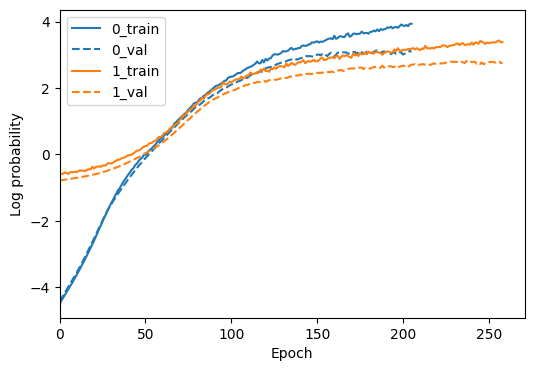

In [6]:
# plot train/validation loss

f, ax = plt.subplots(1, 1, figsize=(6,4))

c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])

ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [12]:
# choose a random input
ind = np.random.randint(len(theta))

# generate samples from the posterior
samples = posterior.sample((1000,), x[ind])

# calculate the log_prob for each sample
log_prob = posterior.log_prob(samples, x[ind])

Drawing 523 posterior samples: 613it [00:00, 51396.47it/s]            
Drawing 477 posterior samples: 526it [00:00, 280830.44it/s]           


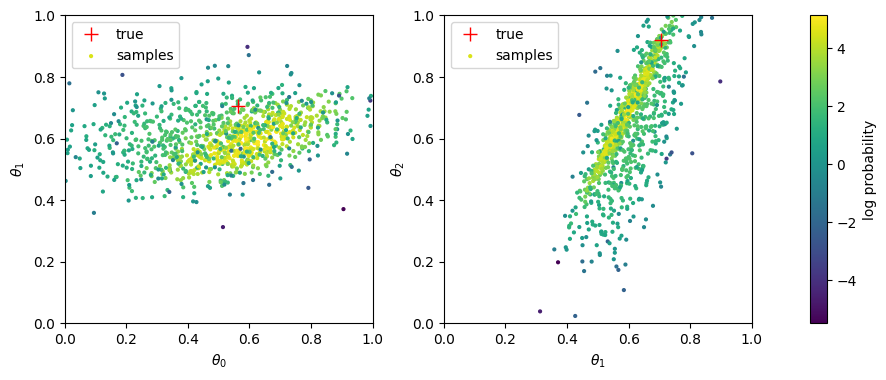

In [13]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 544 posterior samples: 629it [00:00, 48774.58it/s]            
Drawing 456 posterior samples: 494it [00:00, 286661.06it/s]           
/opt/homebrew/anaconda3/envs/ili-sbi/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


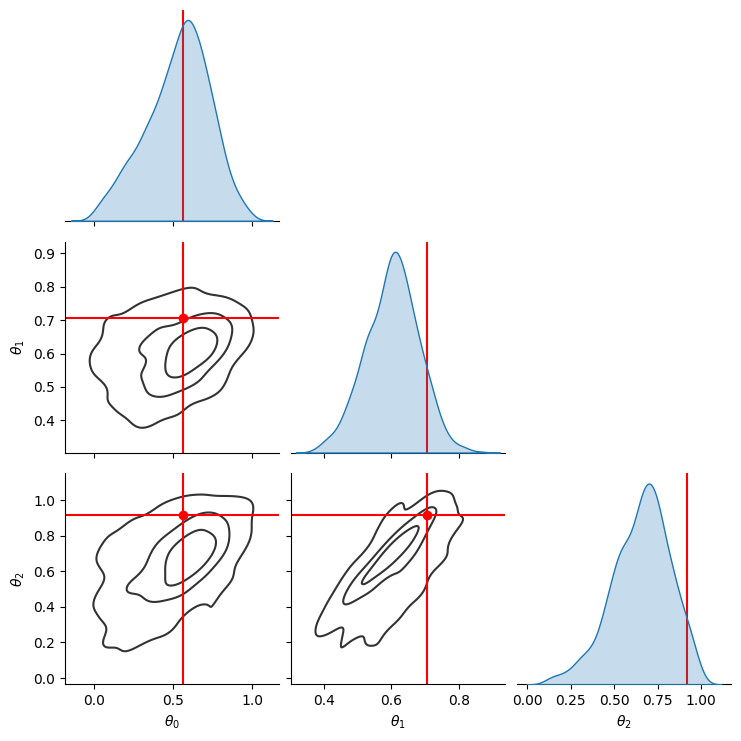

In [14]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='pyro', labels=[f'$\\theta_{i}$' for i in range(3)])
f = metric(posterior=posterior, x_obs = x[ind], theta_obs=theta[ind], x=x, theta=theta)

/Users/maho/git/ltu-ili/ili/validation/metrics.py:76: UserWarning: DirectPosterior detected. Ignoring mcmc sampler parameters.
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:02<00:00, 86.58it/s]


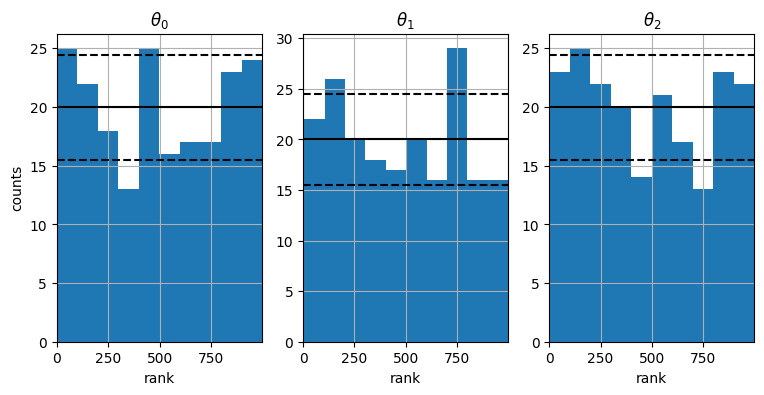

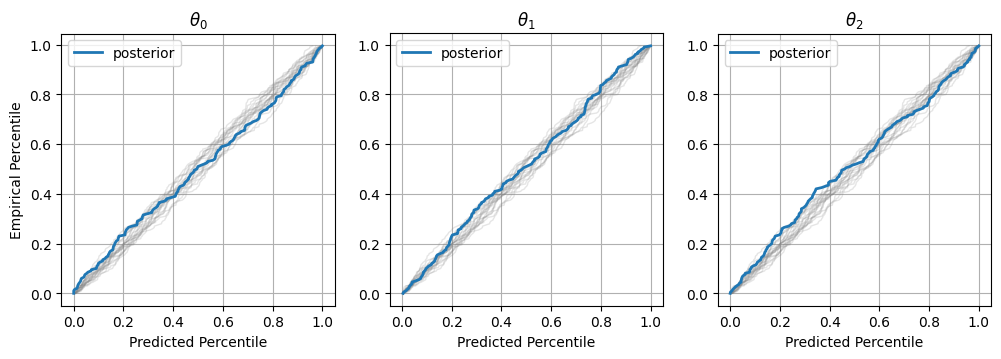

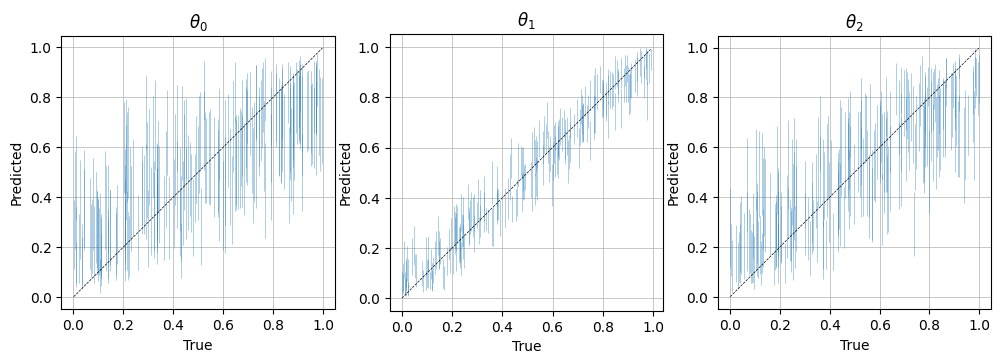

In [10]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PlotRankStatistics(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='pyro', labels=[f'$\\theta_{i}$' for i in range(3)])
f = metric(posterior=posterior, x_obs = x[ind], theta_obs=theta[ind], x=x, theta=theta)

100%|██████████| 200/200 [00:02<00:00, 87.61it/s]


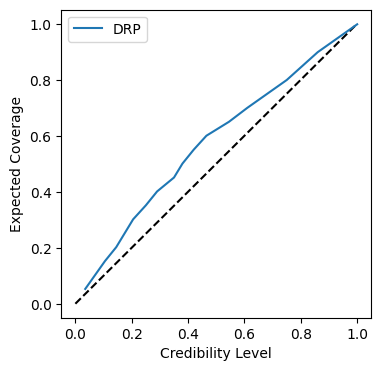

In [11]:
# calculate and plot the TARP metric to describe multivariate posterior coverage
metric = TARP(
    backend='sbi', output_path=None, num_samples=1000, 
    sample_method='pyro', labels=[f'$\\theta_{i}$' for i in range(3)])
f = metric(posterior=posterior, x_obs = x[ind], theta_obs=theta[ind], x=x, theta=theta)

From these results, we see that we are largely consistent and calibrated, with some slight bias shown in the multivariate coverage. This can potentially be addressed by increasing the size of our ensemble.

## Toy SNLE
This example uses the same dataset as the previous SNPE example, but uses a likelihood estimation model instead of an amortized posterior estimation.